# Домашнее задание: Physics-Informed Neural Networks (PINNs)
В этой домашней работе мы:
- Решим **прямую задачу**: получим решение уравнения теплопроводности
- Решим **обратную задачу**: восстановим функцию источника тепла из решения прямой задачи и из точного решения.

---

## Задача: Уравнение теплопроводности

Рассмотрим 1D уравнение теплопроводности:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + \cos(2 \pi x), \quad x \in [0, 1], \ t \ge 0
$$

Начальные условия: $u(x, 0) = \sin^2(3 \pi x)$  
Граничные условия: $\left. \frac{\partial u(x, t)}{\partial x} \right|_{x=0} = \left. \frac{\partial u(x, t)}{\partial x} \right|_{x=1} = 0$

In [170]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Класс модели PINN

In [214]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            #your_code_here
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.Linear(100, 150),
            nn.Tanh(),  
            nn.Linear(150, 150),
            nn.Tanh(),                  
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        self.residual_conn = nn.Linear(2, 1)

    def forward(self, x):
        out1 = self.model(x)
        out2 = self.residual_conn(x)
        out = out1 + out2
        return out

Выполнение уравнения

In [215]:
def pde_residual(model, x, t):
    x.requires_grad_(True)
    t.requires_grad_(True)
    inputs = torch.cat([x, t], dim=1)
    u = model(inputs)
    
    #your_code_here

    u_t = grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    return u_t - u_xx - torch.cos(2 * np.pi * x) #your_code_here

def analytical_solution(x, t):
    return 1/2 * ( -torch.exp(- 4 * np.pi**2 * t) *torch.cos(2 * np.pi * x) / (2 * np.pi**2) + (2 * (np.pi)**2 + torch.cos(2 * np.pi * x)) / (2 * np.pi**2) - torch.exp(-36 * np.pi**2 * t) * torch.cos(6 * np.pi * x))

## **Прямая задача (Forward Problem)**

В прямой задаче решается классическая задача Коши для одномерного уравнения теплопроводности. Источник тепла известен.

Хотим найти функцию $u(x, t)$, удовлетворяющую начальным, граничным условиям и уравнению теплопроводности.

#### Метод:

* Нейросеть $u_\theta(x, t)$ обучается за счёт минимизации следующей функции потерь:

$$
\mathcal{L}_{\text{Total}} = \mathcal{L}_{\text{IC}} + \mathcal{L}_{\text{BC}} + \mathcal{L}_{\text{PDE}}
$$

где

$$
\mathcal{L}_{\text{IC}} = \frac{1}{N_{\text{IC}}} \sum_{i=1}^{N_{\text{IC}}} \left(u_\theta(x_i, 0) - \sin^2(3 \pi x)\right)^2
$$

$$
\mathcal{L}_{\text{BC}} = \frac{1}{N_{\text{BC}}} \sum_{i=1}^{N_{\text{BC}}} \left(\left. \left( \frac{\partial u_\theta(x_i, t_i)}{\partial x} \right|_{x=0}\right)^2 + \left. \left(\frac{\partial u_\theta(x_i, t_i)}{\partial x} \right|_{x=1} \right)^2\right)
$$

$$
\mathcal{L}_{\text{PDE}} = \frac{1}{N_{\text{PDE}}} \sum_{i=1}^{N_{\text{PDE}}} \left( \frac{\partial u_\theta}{\partial t}(x_i, t_i) - \frac{\partial^2 u_\theta}{\partial x^2}(x_i, t_i) - \cos(2 \pi x)\right)^2
$$



### Обучение Forward PINN (2 балла)

Обучите Forward PINN и восстановите $u(x,t)$, сравните его с точным решением. Обратите внимание, что в этом пункте для обучения PINN запрещено использовать аналитическое решение. Модель не должна знать ничего кроме уравнений и условий к нему.

In [216]:
def initial_condition(x):
    return (torch.sin(3 * np.pi * x))**2 #your_code_here

def boundary_condition(t):
    return torch.zeros_like(t) #your_code_here

def train_forward(model, n_ic=100, n_bc=100, n_pde=5000, epochs=3000, lr=1e-3):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500, 2000, 2500], gamma=0.01)

    x_ic = torch.rand(n_ic, 1).to(device)
    t_ic = torch.zeros_like(x_ic).to(device)
    u_ic = initial_condition(x_ic).to(device)

    t_bc = torch.rand(n_bc, 1).to(device)
    x_bc_0 = torch.zeros_like(t_bc).to(device)
    x_bc_1 = torch.ones_like(t_bc).to(device)

    x_pde = torch.rand(n_pde, 1).to(device)
    t_pde = torch.rand(n_pde, 1).to(device)

    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        # IC loss
        u_ic_pred = model(torch.cat([x_ic, t_ic], dim=1))
        loss_ic = nn.MSELoss()(u_ic_pred, u_ic)

        # BC loss
        x_bc_0.requires_grad_(True)
        x_bc_1.requires_grad_(True)
        t_bc.requires_grad_(True)
        
        u_0 = model(torch.cat([x_bc_0, t_bc], dim=1))
        du_dx_0 = grad(u_0, x_bc_0, grad_outputs=torch.ones_like(u_0), create_graph=True)[0]
        u_1 = model(torch.cat([x_bc_1, t_bc], dim=1))
        du_dx_1 = grad(u_1, x_bc_1, grad_outputs=torch.ones_like(u_1), create_graph=True)[0]

        loss_bc = nn.MSELoss()(du_dx_0, boundary_condition(t_bc)) + nn.MSELoss()(du_dx_1, boundary_condition(t_bc))

        # PDE residual loss
        res_pde = pde_residual(model, x_pde, t_pde)
        loss_pde = torch.mean(res_pde**2)

        loss = loss_ic + loss_bc + loss_pde
        loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % 100 == 0:
            print(f"[Epoch {epoch}] Loss: {loss.item():.5f}")

        losses.append(loss.item())
    

    return losses

[Epoch 0] Loss: 1.79246
[Epoch 100] Loss: 0.41109
[Epoch 200] Loss: 0.13073
[Epoch 300] Loss: 0.12989
[Epoch 400] Loss: 0.12947
[Epoch 500] Loss: 0.12922
[Epoch 600] Loss: 0.12905
[Epoch 700] Loss: 0.12892
[Epoch 800] Loss: 0.12881
[Epoch 900] Loss: 0.12871
[Epoch 1000] Loss: 0.12862
[Epoch 1100] Loss: 0.12855
[Epoch 1200] Loss: 0.12848
[Epoch 1300] Loss: 0.12884
[Epoch 1400] Loss: 0.12841
[Epoch 1500] Loss: 0.12836
[Epoch 1600] Loss: 0.12836
[Epoch 1700] Loss: 0.12836
[Epoch 1800] Loss: 0.12836
[Epoch 1900] Loss: 0.12836
[Epoch 2000] Loss: 0.12836
[Epoch 2100] Loss: 0.12836
[Epoch 2200] Loss: 0.12836
[Epoch 2300] Loss: 0.12836
[Epoch 2400] Loss: 0.12836
[Epoch 2500] Loss: 0.12836
[Epoch 2600] Loss: 0.12836
[Epoch 2700] Loss: 0.12836
[Epoch 2800] Loss: 0.12836
[Epoch 2900] Loss: 0.12836


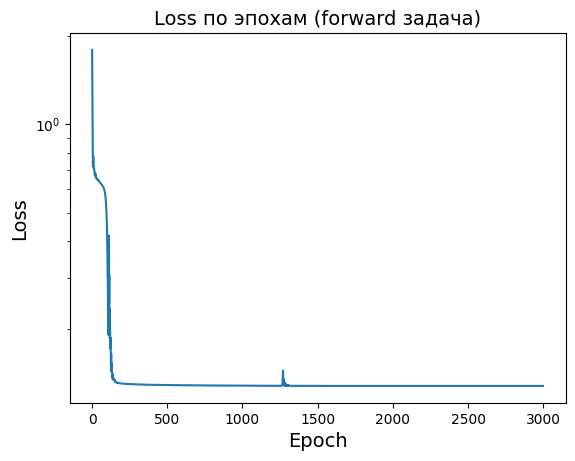

In [217]:
model_forward = PINN().to(device)

losses_forward = train_forward(model_forward)

plt.plot(losses_forward)
plt.title("Loss по эпохам (forward задача)", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.yscale("log")
plt.show()

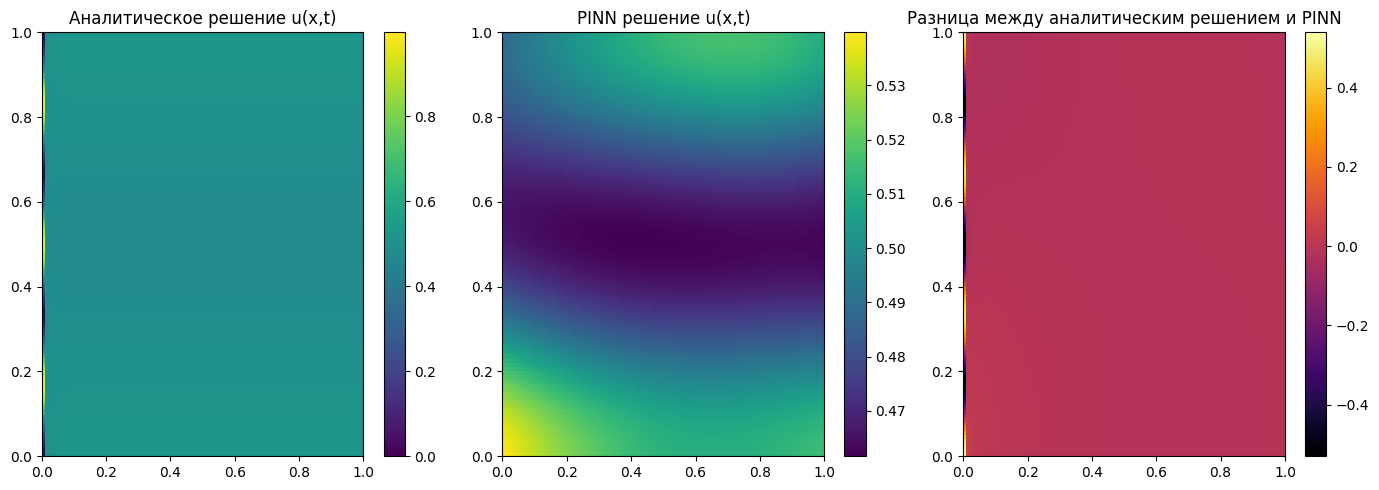

In [218]:
# Создание сетки
x_grid = torch.linspace(0, 1, 100).reshape(-1, 1)
t_grid = torch.linspace(0, 1, 100).reshape(-1, 1)
x_mesh, t_mesh = torch.meshgrid(x_grid.squeeze(), t_grid.squeeze(), indexing='ij')
x_flat = x_mesh.reshape(-1, 1).to(device)
t_flat = t_mesh.reshape(-1, 1).to(device)

# Аналитическое решение
u_exact = analytical_solution(x_flat, t_flat).cpu().detach().numpy().reshape(100, 100)

# PINN решение
with torch.no_grad():
    u_pred = model_forward(torch.cat([x_flat, t_flat], dim=1)).cpu().numpy().reshape(100, 100)

# Визуализация
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

c1 = axs[0].imshow(u_exact, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='viridis')
axs[0].set_title("Аналитическое решение u(x,t)")
fig.colorbar(c1, ax=axs[0])

c2 = axs[1].imshow(u_pred, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='viridis')
axs[1].set_title("PINN решение u(x,t)")
fig.colorbar(c2, ax=axs[1])

c3 = axs[2].imshow(u_pred - u_exact, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='inferno')
axs[2].set_title("Разница между аналитическим решением и PINN")
fig.colorbar(c3, ax=axs[2])

plt.tight_layout()
plt.show()

## Эксперимент с оптимизатором (LBFGS)

[Epoch 0] Loss: 1.04341
[Epoch 100] Loss: 0.13642
[Epoch 200] Loss: 0.12478
[Epoch 300] Loss: 0.12461
[Epoch 400] Loss: 0.12461
[Epoch 500] Loss: 0.12460
[Epoch 600] Loss: 0.12460
[Epoch 700] Loss: 0.12460
[Epoch 800] Loss: 0.12460
[Epoch 900] Loss: 0.12460


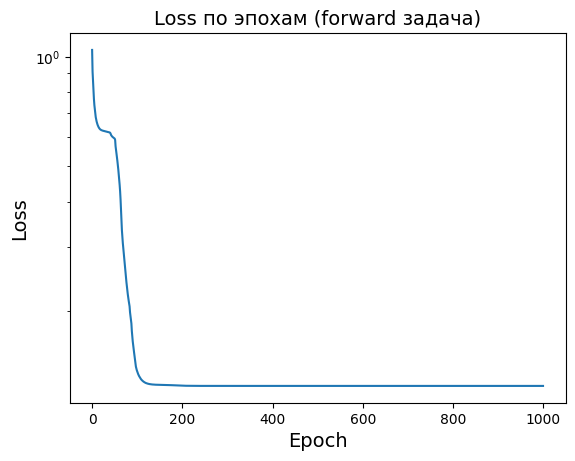

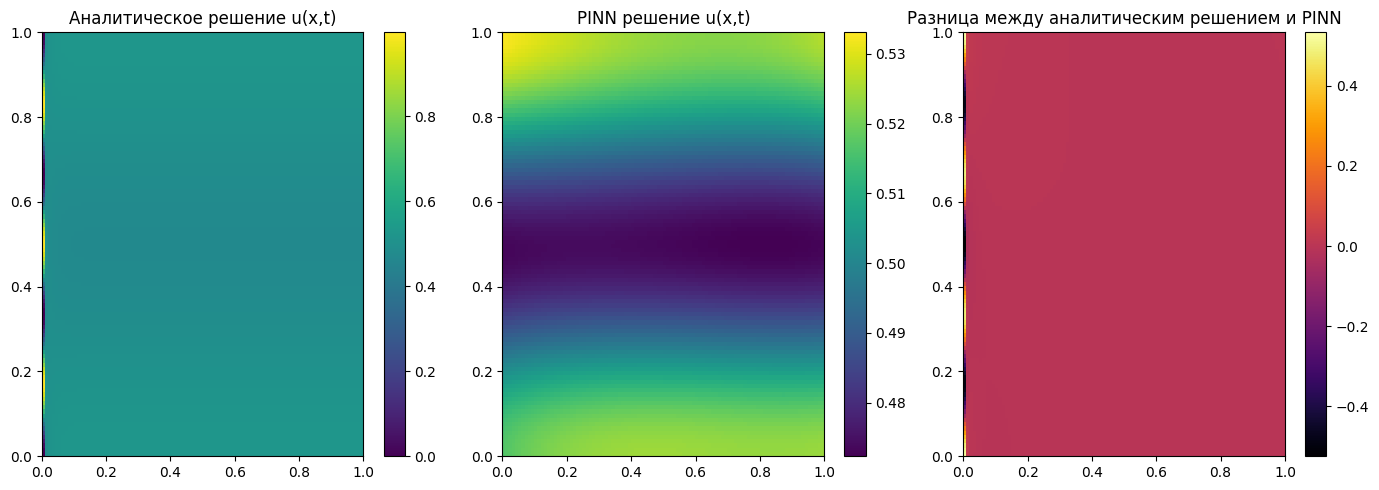

In [199]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            #your_code_here
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.Linear(100, 150),
            nn.Tanh(),          
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        self.residual_conn = nn.Linear(2, 1)

    def forward(self, x):
        out1 = self.model(x)
        out2 = self.residual_conn(x)
        out = out1 + out2
        return out
    
def initial_condition(x):
    return (torch.sin(3 * np.pi * x))**2 #your_code_here

def boundary_condition(t):
    return torch.zeros_like(t) #your_code_here

def train_forward(model, n_ic=100, n_bc=100, n_pde=5000, epochs=1000, lr=1e-3):
    optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[800, 900], gamma=0.01)

    x_ic = torch.rand(n_ic, 1).to(device)
    t_ic = torch.zeros_like(x_ic).to(device)
    u_ic = initial_condition(x_ic).to(device)

    t_bc = torch.rand(n_bc, 1).to(device)
    x_bc_0 = torch.zeros_like(t_bc).to(device)
    x_bc_1 = torch.ones_like(t_bc).to(device)

    x_pde = torch.rand(n_pde, 1).to(device)
    t_pde = torch.rand(n_pde, 1).to(device)

    losses = []

    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()

            # IC loss
            u_ic_pred = model(torch.cat([x_ic, t_ic], dim=1))
            loss_ic = nn.MSELoss()(u_ic_pred, u_ic)

            # BC loss
            x_bc_0.requires_grad_(True)
            x_bc_1.requires_grad_(True)
            t_bc.requires_grad_(True)
            
            u_0 = model(torch.cat([x_bc_0, t_bc], dim=1))
            du_dx_0 = grad(u_0, x_bc_0, grad_outputs=torch.ones_like(u_0), create_graph=True)[0]
            u_1 = model(torch.cat([x_bc_1, t_bc], dim=1))
            du_dx_1 = grad(u_1, x_bc_1, grad_outputs=torch.ones_like(u_1), create_graph=True)[0]

            loss_bc = nn.MSELoss()(du_dx_0, boundary_condition(t_bc)) + nn.MSELoss()(du_dx_1, boundary_condition(t_bc))

            # PDE residual loss
            res_pde = pde_residual(model, x_pde, t_pde)
            loss_pde = torch.mean(res_pde**2)

            loss = loss_ic + loss_bc + loss_pde
            loss.backward()
            return loss
        
        loss = closure()
        optimizer.step(closure)
        scheduler.step()

        if epoch % 100 == 0:
            print(f"[Epoch {epoch}] Loss: {loss.item():.5f}")

        losses.append(loss.item())
    

    return losses    

model_forward = PINN().to(device)

losses_forward = train_forward(model_forward)

plt.plot(losses_forward)
plt.title("Loss по эпохам (forward задача)", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.yscale("log")
plt.show()

# Создание сетки
x_grid = torch.linspace(0, 1, 100).reshape(-1, 1)
t_grid = torch.linspace(0, 1, 100).reshape(-1, 1)
x_mesh, t_mesh = torch.meshgrid(x_grid.squeeze(), t_grid.squeeze(), indexing='ij')
x_flat = x_mesh.reshape(-1, 1).to(device)
t_flat = t_mesh.reshape(-1, 1).to(device)

# Аналитическое решение
u_exact = analytical_solution(x_flat, t_flat).cpu().detach().numpy().reshape(100, 100)

# PINN решение
with torch.no_grad():
    u_pred = model_forward(torch.cat([x_flat, t_flat], dim=1)).cpu().numpy().reshape(100, 100)

# Визуализация
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

c1 = axs[0].imshow(u_exact, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='viridis')
axs[0].set_title("Аналитическое решение u(x,t)")
fig.colorbar(c1, ax=axs[0])

c2 = axs[1].imshow(u_pred, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='viridis')
axs[1].set_title("PINN решение u(x,t)")
fig.colorbar(c2, ax=axs[1])

c3 = axs[2].imshow(u_pred - u_exact, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='inferno')
axs[2].set_title("Разница между аналитическим решением и PINN")
fig.colorbar(c3, ax=axs[2])

plt.tight_layout()
plt.show()

## Эксперимент с архитектурой (и без scheduler)

[Epoch 0] Loss: 1.14246
[Epoch 100] Loss: 0.11737
[Epoch 200] Loss: 0.11569
[Epoch 300] Loss: 0.11506
[Epoch 400] Loss: 0.11497
[Epoch 500] Loss: 0.11483
[Epoch 600] Loss: 0.11467
[Epoch 700] Loss: 0.11476
[Epoch 800] Loss: 0.11456
[Epoch 900] Loss: 0.11447
[Epoch 1000] Loss: 0.11460
[Epoch 1100] Loss: 0.11436
[Epoch 1200] Loss: 0.11425
[Epoch 1300] Loss: 0.11442
[Epoch 1400] Loss: 0.11422
[Epoch 1500] Loss: 0.11416
[Epoch 1600] Loss: 0.11421
[Epoch 1700] Loss: 0.11414
[Epoch 1800] Loss: 0.11410
[Epoch 1900] Loss: 0.11418
[Epoch 2000] Loss: 0.11410
[Epoch 2100] Loss: 0.11508
[Epoch 2200] Loss: 0.11410
[Epoch 2300] Loss: 0.11557
[Epoch 2400] Loss: 0.11406
[Epoch 2500] Loss: 0.11421
[Epoch 2600] Loss: 0.11404
[Epoch 2700] Loss: 0.11402
[Epoch 2800] Loss: 0.11406
[Epoch 2900] Loss: 0.11401


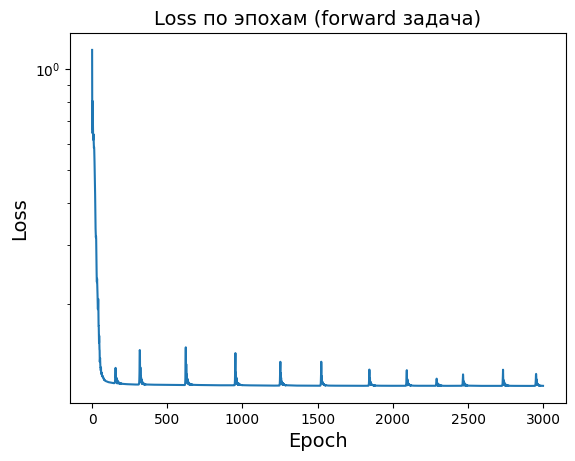

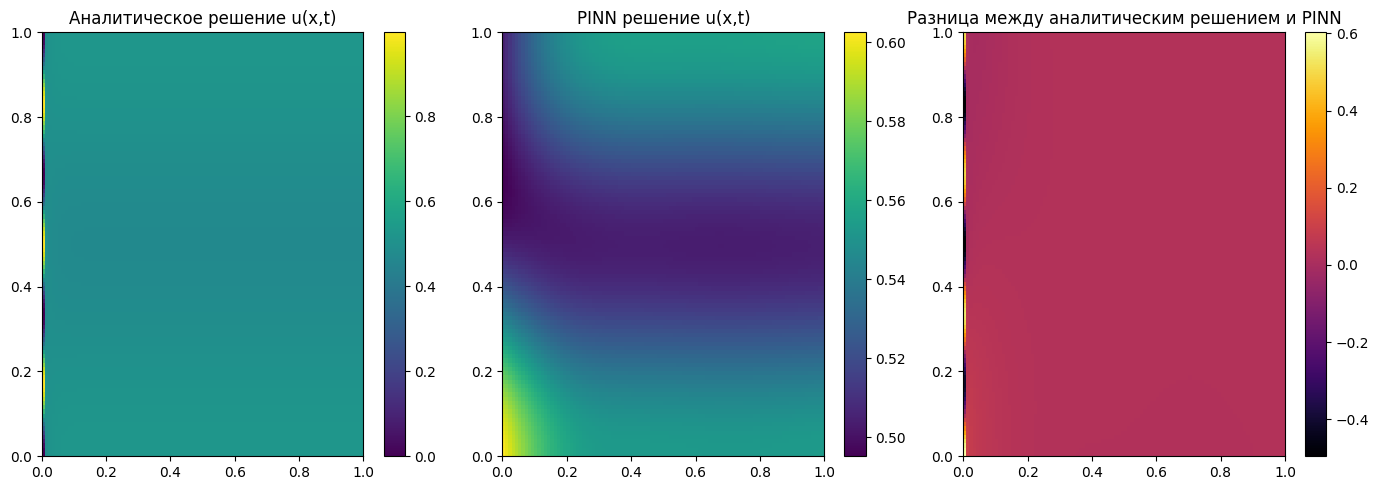

In [220]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            #your_code_here
            nn.Linear(2, 300),
            nn.Tanh(),
            nn.Linear(300, 300),
            nn.Tanh(),
            nn.Linear(300, 300),
            nn.Tanh(),          
             nn.Linear(300, 300),
            nn.Tanh(),
            nn.Linear(300, 1)
        )
        self.residual_conn = nn.Linear(2, 1)

    def forward(self, x):
        out1 = self.model(x)
        out2 = self.residual_conn(x)
        out = out1 + out2
        return out
    
def initial_condition(x):
    return (torch.sin(3 * np.pi * x))**2 #your_code_here

def boundary_condition(t):
    return torch.zeros_like(t) #your_code_here

def train_forward(model, n_ic=100, n_bc=100, n_pde=5000, epochs=3000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    x_ic = torch.rand(n_ic, 1).to(device)
    t_ic = torch.zeros_like(x_ic).to(device)
    u_ic = initial_condition(x_ic).to(device)

    t_bc = torch.rand(n_bc, 1).to(device)
    x_bc_0 = torch.zeros_like(t_bc).to(device)
    x_bc_1 = torch.ones_like(t_bc).to(device)

    x_pde = torch.rand(n_pde, 1).to(device)
    t_pde = torch.rand(n_pde, 1).to(device)

    losses = []

    for epoch in range(epochs):
        
        optimizer.zero_grad()

        # IC loss
        u_ic_pred = model(torch.cat([x_ic, t_ic], dim=1))
        loss_ic = nn.MSELoss()(u_ic_pred, u_ic)

        # BC loss
        x_bc_0.requires_grad_(True)
        x_bc_1.requires_grad_(True)
        t_bc.requires_grad_(True)
        
        u_0 = model(torch.cat([x_bc_0, t_bc], dim=1))
        du_dx_0 = grad(u_0, x_bc_0, grad_outputs=torch.ones_like(u_0), create_graph=True)[0]
        u_1 = model(torch.cat([x_bc_1, t_bc], dim=1))
        du_dx_1 = grad(u_1, x_bc_1, grad_outputs=torch.ones_like(u_1), create_graph=True)[0]

        loss_bc = nn.MSELoss()(du_dx_0, boundary_condition(t_bc)) + nn.MSELoss()(du_dx_1, boundary_condition(t_bc))

        # PDE residual loss
        res_pde = pde_residual(model, x_pde, t_pde)
        loss_pde = torch.mean(res_pde**2)

        loss = loss_ic + loss_bc + loss_pde

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"[Epoch {epoch}] Loss: {loss.item():.5f}")

        losses.append(loss.item())
    

    return losses    

model_forward = PINN().to(device)

losses_forward = train_forward(model_forward)

plt.plot(losses_forward)
plt.title("Loss по эпохам (forward задача)", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.yscale("log")
plt.show()

# Создание сетки
x_grid = torch.linspace(0, 1, 100).reshape(-1, 1)
t_grid = torch.linspace(0, 1, 100).reshape(-1, 1)
x_mesh, t_mesh = torch.meshgrid(x_grid.squeeze(), t_grid.squeeze(), indexing='ij')
x_flat = x_mesh.reshape(-1, 1).to(device)
t_flat = t_mesh.reshape(-1, 1).to(device)

# Аналитическое решение
u_exact = analytical_solution(x_flat, t_flat).cpu().detach().numpy().reshape(100, 100)

# PINN решение
with torch.no_grad():
    u_pred = model_forward(torch.cat([x_flat, t_flat], dim=1)).cpu().numpy().reshape(100, 100)

# Визуализация
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

c1 = axs[0].imshow(u_exact, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='viridis')
axs[0].set_title("Аналитическое решение u(x,t)")
fig.colorbar(c1, ax=axs[0])

c2 = axs[1].imshow(u_pred, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='viridis')
axs[1].set_title("PINN решение u(x,t)")
fig.colorbar(c2, ax=axs[1])

c3 = axs[2].imshow(u_pred - u_exact, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='inferno')
axs[2].set_title("Разница между аналитическим решением и PINN")
fig.colorbar(c3, ax=axs[2])

plt.tight_layout()
plt.show()

## Эксперимент с Loss

[Epoch 0] Loss: 534.71381
[Epoch 100] Loss: 0.81407
[Epoch 200] Loss: 0.71931
[Epoch 300] Loss: 0.67617
[Epoch 400] Loss: 0.65082
[Epoch 500] Loss: 0.63652
[Epoch 600] Loss: 0.62885
[Epoch 700] Loss: 0.62475
[Epoch 800] Loss: 0.62244
[Epoch 900] Loss: 0.62097
[Epoch 1000] Loss: 0.61992
[Epoch 1100] Loss: 0.61912
[Epoch 1200] Loss: 0.61850
[Epoch 1300] Loss: 0.61800
[Epoch 1400] Loss: 0.61762
[Epoch 1500] Loss: 0.61732
[Epoch 1600] Loss: 0.61732
[Epoch 1700] Loss: 0.61731
[Epoch 1800] Loss: 0.61731
[Epoch 1900] Loss: 0.61731
[Epoch 2000] Loss: 0.61730
[Epoch 2100] Loss: 0.61730
[Epoch 2200] Loss: 0.61730
[Epoch 2300] Loss: 0.61730
[Epoch 2400] Loss: 0.61730
[Epoch 2500] Loss: 0.61730
[Epoch 2600] Loss: 0.61730
[Epoch 2700] Loss: 0.61730
[Epoch 2800] Loss: 0.61730
[Epoch 2900] Loss: 0.61730


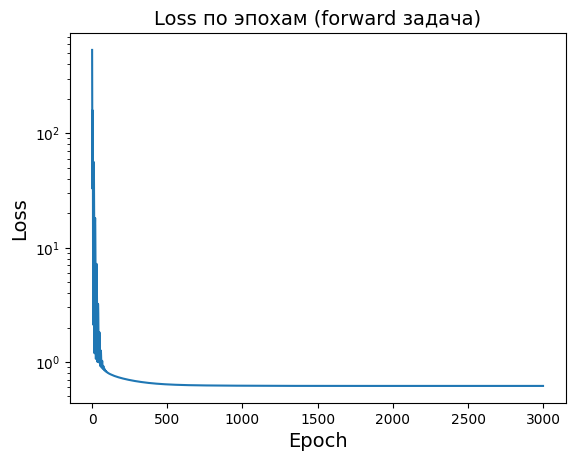

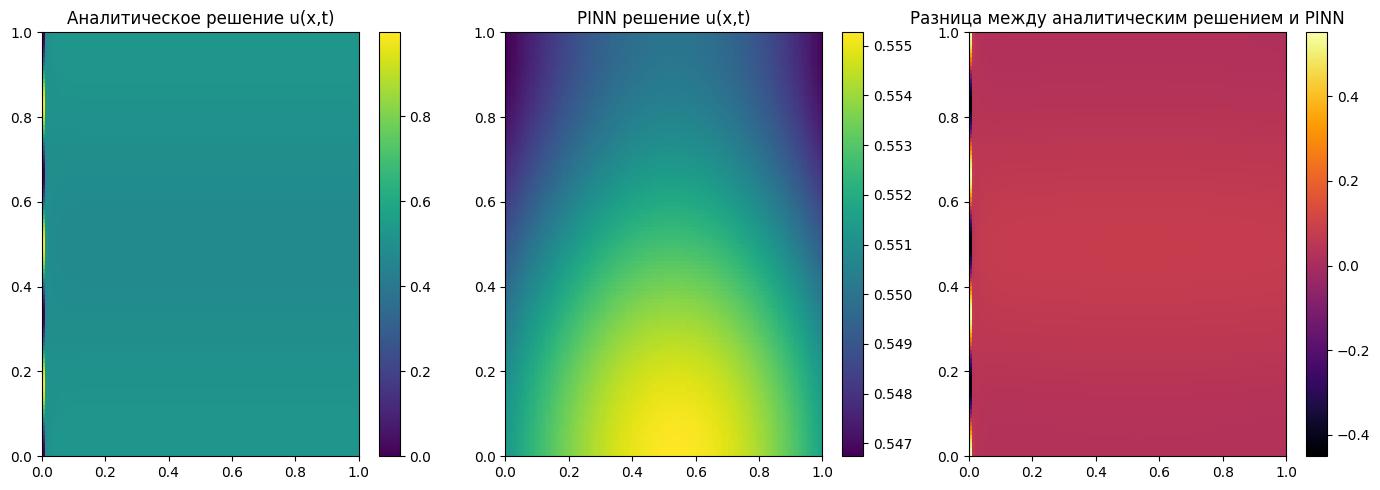

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            #your_code_here
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.Linear(100, 150),
            nn.Tanh(),          
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        self.residual_conn = nn.Linear(2, 1)

    def forward(self, x):
        out1 = self.model(x)
        out2 = self.residual_conn(x)
        out = out1 + out2
        return out
    
def initial_condition(x):
    return (torch.sin(3 * np.pi * x))**2 #your_code_here

def boundary_condition(t):
    return torch.zeros_like(t) #your_code_here

def train_forward(model, n_ic=100, n_bc=100, n_pde=5000, epochs=3000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500, 2000, 2500], gamma=0.01)

    x_ic = torch.rand(n_ic, 1).to(device)
    t_ic = torch.zeros_like(x_ic).to(device)
    u_ic = initial_condition(x_ic).to(device)

    t_bc = torch.rand(n_bc, 1).to(device)
    x_bc_0 = torch.zeros_like(t_bc).to(device)
    x_bc_1 = torch.ones_like(t_bc).to(device)

    x_pde = torch.rand(n_pde, 1).to(device)
    t_pde = torch.rand(n_pde, 1).to(device)

    losses = []

    for epoch in range(epochs):
        
        optimizer.zero_grad()

        # IC loss
        u_ic_pred = model(torch.cat([x_ic, t_ic], dim=1))
        loss_ic = nn.MSELoss()(u_ic_pred, u_ic)

        # BC loss
        x_bc_0.requires_grad_(True)
        x_bc_1.requires_grad_(True)
        t_bc.requires_grad_(True)
        
        u_0 = model(torch.cat([x_bc_0, t_bc], dim=1))
        du_dx_0 = grad(u_0, x_bc_0, grad_outputs=torch.ones_like(u_0), create_graph=True)[0]
        u_1 = model(torch.cat([x_bc_1, t_bc], dim=1))
        du_dx_1 = grad(u_1, x_bc_1, grad_outputs=torch.ones_like(u_1), create_graph=True)[0]

        loss_bc = nn.MSELoss()(du_dx_0, boundary_condition(t_bc)) + nn.MSELoss()(du_dx_1, boundary_condition(t_bc))

        # PDE residual loss
        res_pde = pde_residual(model, x_pde, t_pde)
        loss_pde = torch.mean(res_pde**2)

        loss = loss_ic + 10000 * loss_bc + loss_pde #акцентируем внимание на границах

        loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % 100 == 0:
            print(f"[Epoch {epoch}] Loss: {loss.item():.5f}")

        losses.append(loss.item())
    

    return losses    

model_forward = PINN().to(device)

losses_forward = train_forward(model_forward)

plt.plot(losses_forward)
plt.title("Loss по эпохам (forward задача)", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.yscale("log")
plt.show()

# Создание сетки
x_grid = torch.linspace(0, 1, 100).reshape(-1, 1)
t_grid = torch.linspace(0, 1, 100).reshape(-1, 1)
x_mesh, t_mesh = torch.meshgrid(x_grid.squeeze(), t_grid.squeeze(), indexing='ij')
x_flat = x_mesh.reshape(-1, 1).to(device)
t_flat = t_mesh.reshape(-1, 1).to(device)

# Аналитическое решение
u_exact = analytical_solution(x_flat, t_flat).cpu().detach().numpy().reshape(100, 100)

# PINN решение
with torch.no_grad():
    u_pred = model_forward(torch.cat([x_flat, t_flat], dim=1)).cpu().numpy().reshape(100, 100)

# Визуализация
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

c1 = axs[0].imshow(u_exact, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='viridis')
axs[0].set_title("Аналитическое решение u(x,t)")
fig.colorbar(c1, ax=axs[0])

c2 = axs[1].imshow(u_pred, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='viridis')
axs[1].set_title("PINN решение u(x,t)")
fig.colorbar(c2, ax=axs[1])

c3 = axs[2].imshow(u_pred - u_exact, extent=[0,1,0,1], origin='lower', aspect='auto', cmap='inferno')
axs[2].set_title("Разница между аналитическим решением и PINN")
fig.colorbar(c3, ax=axs[2])

plt.tight_layout()
plt.show()

## **Обратная задача (Inverse Problem)**

В обратной задаче предполагается, что функция источника тепла неизвестна, и ее необходимо восстановить.

У нас есть наблюдаемые значения функции $u(x, t)$ в ограниченном числе точек: $$\{(x_i, t_i, u_i^{\text{obs}})\}_{i=1}^{N_{\text{obs}}}$$

Хотим восстановить $f(x)$ по наблюдаемым данным.

#### Метод:

Обучаем нейросеть $u_\theta(x, t)$ и оптимизируем параметр $f(x)$, минимизируя:

$$
\mathcal{L}_{\text{Total}} = \mathcal{L}_{\text{data}} + \mathcal{L}_{\text{PDE}}
$$

где

$$
\mathcal{L}_{\text{data}} = \frac{1}{N_{\text{obs}}} \sum_{i=1}^{N_{\text{obs}}} \left(u_\theta(x_i, t_i) - u_i^{\text{obs}}\right)^2
$$

$$
\mathcal{L}_{\text{PDE}} = \frac{1}{N_{\text{PDE}}} \sum_{i=1}^{N_{\text{PDE}}} \left( \frac{\partial u_\theta}{\partial t}(x_i, t_i) - \frac{\partial^2 u_\theta}{\partial x^2}(x_i, t_i) - f(x)\right)^2
$$



### Обучение Inverse PINN на основе аналитического результата (4 балла)

Обучите нейронную сеть восстанавливать $f(x)$ из аналитического решения. Можете пользоваться любыми хаками и улучшениями, но главное -- не показывать нейронной сети информацию об $f(x)$. 
P.S. возможно, вам потребуется поменять архитектуру нейронной сети, чтобы на выходе помимо $u(x,t)$ выдавалась $f(x)$. Можете пойти и другим путем, например, создать отдельную маленькую нейронную сеть для $f(x)$, которая будет принимать на вход, соответственно, только $x$. Feel free to experiment

In [174]:
def generate_data_points(n_obs, n_pde):
    x_obs = torch.rand(n_obs, 1)
    t_obs = torch.rand(n_obs, 1)
    x_pde = torch.rand(n_pde, 1)
    t_pde = torch.rand(n_pde, 1)
    return x_obs, t_obs, x_pde, t_pde

In [ ]:
class PINN_inverse(nn.Module):
        def __init__(self):
            super().__init__()

            self.model = nn.Sequential(
                nn.Linear(2, 50),
                nn.Tanh(),
                nn.Linear(50, 50),
                nn.Tanh(),
                nn.Linear(50, 50),
                nn.Tanh(),
                nn.Linear(50, 1)
            )
            self.f_x = nn.Linear(2, 1)

        def forward(self, x):
            u_x_t = self.model(x) 
            f_x = self.f_x(x)
            out = u_x_t + f_x
            return out, f_x
        
def pde_residual(model, x, t):
    x.requires_grad_(True)
    t.requires_grad_(True)
    inputs = torch.cat([x, t], dim=1)
    u, _ = model(inputs)
    
    #your_code_here

    u_t = grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    return u_t - u_xx - torch.cos(2 * np.pi * x) #your_code_here

def train_inverse(model, n_obs=200, n_pde=5000, epochs=3000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    x_obs, t_obs, x_pde, t_pde = generate_data_points(n_obs, n_pde)
    x_obs = x_obs.to(device)
    t_obs = t_obs.to(device)
    x_pde = x_pde.to(device)
    t_pde = t_pde.to(device)

    u_obs = analytical_solution(x_obs, t_obs).detach().to(device)

    #your_code_here

    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()

        res_pde = pde_residual(model, x_pde, t_pde)
        loss_pde =  torch.mean(res_pde**2) #your_code_here

        u_preds, f_x = model(torch.cat([x_obs, t_obs], dim=1))
        loss_data = nn.MSELoss()(u_preds, u_obs)  #your_code_here

        loss = loss_pde + loss_data
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"[Epoch {epoch}] Loss: {loss.item():.5f}")

        losses.append(loss.item())

    return losses, x_obs, t_obs #your_code_here

#### Запуск и визуализация результатов

Визуализируйте результаты, нарисуйте на одном графике $f(x)$, полученную при помощи PINN и сравните его с точной функцией источника тепла $f(x) = \cos(2 \pi x)$.

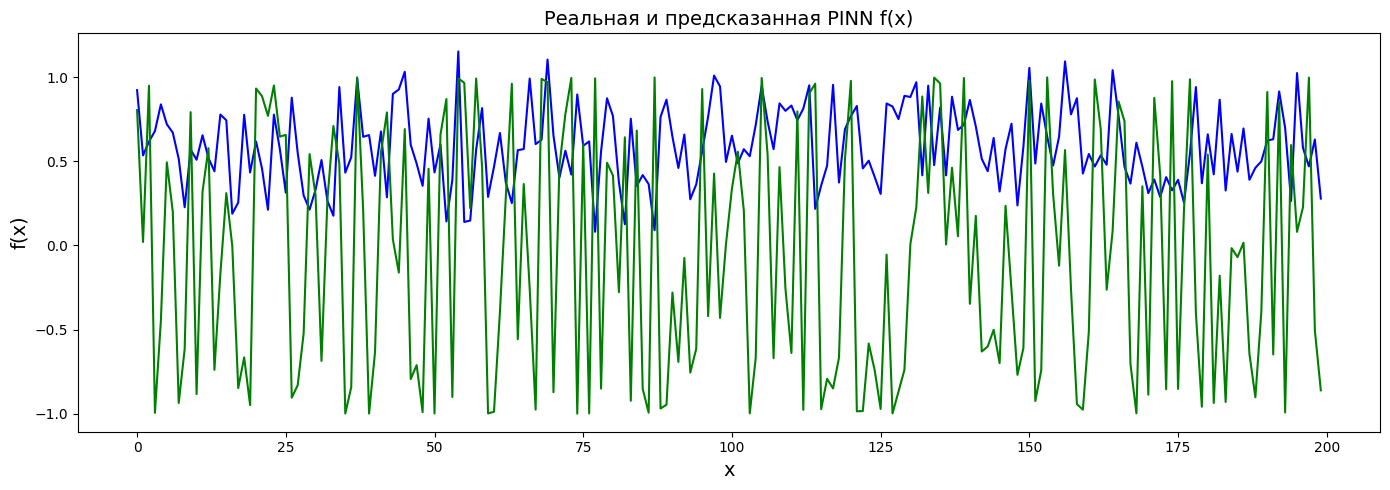

In [ ]:
#your_code_here

model_inverse = PINN_inverse().to(device)
losses, x_obs, t_obs = train_inverse(model_inverse)
_, f_x_pred = model_inverse(torch.cat([x_obs, t_obs], dim=1))
f_x_pred = f_x_pred.detach().numpy()
f_x_real = torch.cos(2 * np.pi * x_obs)

# Визуализация
plt.figure(figsize=(14, 5))

plt.plot(f_x_pred, color='b', label='Predicted PINN f(x)')
plt.plot(f_x_real, color='g', label='Real f(x)')
plt.title("Реальная и предсказанная PINN f(x)", fontsize=14)
plt.xlabel("x", fontsize=14)
plt.ylabel("f(x)", fontsize=14)

plt.tight_layout()
plt.show()

### Inverse PINN на основе ответов Forward PINN (4 балла)

Обучите обратный PINN на основе ответов Forward PINN. Соответственно, Forward PINN знает об источнике тепла, а обратный PINN пытается его восстановить.

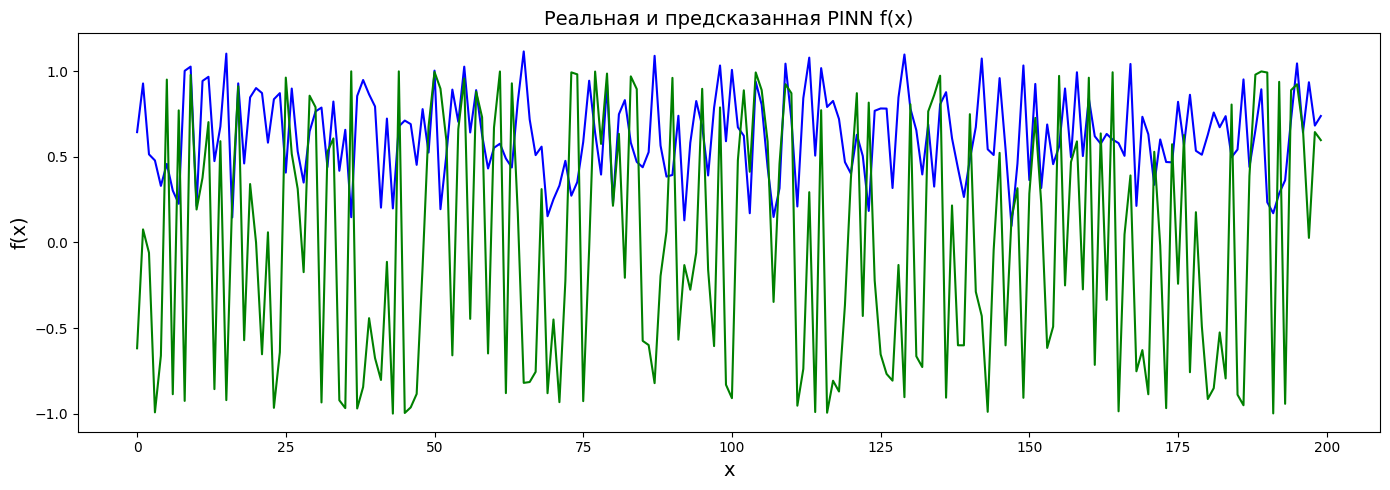

In [ ]:
#your_code_here
x_obs, t_obs, x_pde, t_pde = generate_data_points(n_obs=200, n_pde=5000)
u_obs_analitics = analytical_solution(x_obs, t_obs)
#получаем U(x, t), предсказанное forward PINN
u_obs_PINN = model_forward(torch.cat([x_obs, t_obs], dim=1))
u_obs_PINN = u_obs_PINN.detach().numpy()
#подставляем предикт forward PINN как u_obs (реальное наблюдаемое U(x, t))
def train_inverse_after_forward(model, x_obs, t_obs, x_pde, t_pde, u_obs, n_obs=200, n_pde=5000, epochs=3000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()

        res_pde = pde_residual(model, x_pde, t_pde)
        loss_pde =  torch.mean(res_pde**2) #your_code_here

        u_preds, f_x = model(torch.cat([x_obs, t_obs], dim=1))
        loss_data = nn.MSELoss()(u_preds, u_obs)  #your_code_here

        loss = loss_pde + loss_data
        loss.backward(retain_graph=True)
        optimizer.step()

        if epoch % 100 == 0:
            print(f"[Epoch {epoch}] Loss: {loss.item():.5f}")

        losses.append(loss.item())

    return losses, x_obs, t_obs #your_code_here

model_inverse_2 = PINN_inverse().to(device)
losses, x_obs, t_obs = train_inverse_after_forward(model_inverse_2, x_obs, t_obs, x_pde, t_pde, u_obs_PINN)
u_invrs, f_x_pred = model_inverse(torch.cat([x_obs, t_obs], dim=1))
f_x_pred = f_x_pred.detach().numpy()
u_invrs = u_invrs.detach().numpy()
f_x_real = torch.cos(2 * np.pi * x_obs)

# Визуализация
plt.figure(figsize=(14, 5))
plt.plot(f_x_pred, color='b', label='Predicted PINN f(x)')
plt.plot(f_x_real, color='g', label='Real f(x)')
plt.title("Реальная и предсказанная PINN f(x)", fontsize=14)
plt.xlabel("x", fontsize=14)
plt.ylabel("f(x)", fontsize=14)
plt.tight_layout()
plt.show()


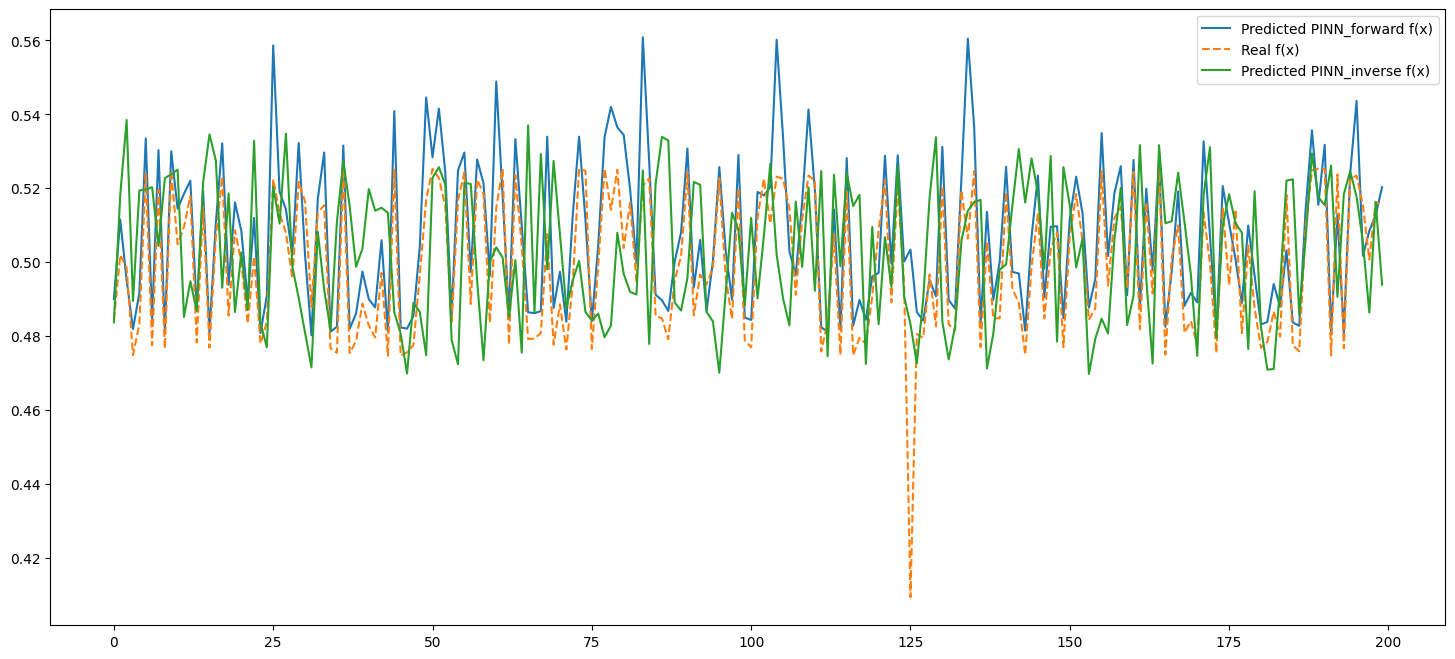

In [ ]:
# Визуализация
plt.figure(figsize=(18, 8))

plt.plot(u_obs_PINN, label='Predicted PINN_forward f(x)')
plt.plot(u_obs_analitics, label='Real f(x)', linestyle='--')
plt.plot(u_invrs, label='Predicted PINN_inverse f(x)')
plt.legend()
plt.show()